<a href="https://colab.research.google.com/github/SSSpock/style_rag/blob/main/style_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pinecone-client
# !pip install openai
# !pip install python-dotenv
# !pip install datasets
# !pip install transformers

In [ ]:
import json
import os
import pinecone
import openai
import requests
import numpy as np
import itertools
import torch
import random
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored
from urllib.parse import urlparse
from pathlib import Path
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
from openai import OpenAI
from PIL import Image
from imageio import imread
from io import BytesIO

In [ ]:
from google.colab import userdata

open_ai_api_key = userdata.get('openai_key')

In [ ]:
os.environ["PINECONE_URL"] = os.getenv("PINECONE_URL")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_CSE_ID"] = os.getenv("GOOGLE_CSE_ID_IMAGES")

pinecone.init(api_key=PINECONE_API_KEY, environment="gcp-starter")
if "tunl-clip" not in pinecone.list_indexes():
    pinecone.create_index(name="tunl-clip", metric="cosine", shards=1, dimension=512)
index = pinecone.Index("tunl-clip")

openai.api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI()
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

out = model.to(device)

In [ ]:
styles = [
    "Cottagecore",
    "Dark Academia",
    "Cyberpunk",
    "Fairycore",
    "Vanilla Girl",
    "Y2K",
    "Skater",
    "VSCO girl",
    "Softgirl",
    "Coastal Grandma",
    "Angelcore"
]

def get_styles(query, num_results=10):
    url = "https://www.googleapis.com/customsearch/v1"

    params = {
        "q" : query + " fashion",
        "cx" : os.getenv("GOOGLE_CSE_ID_IMAGES"),
        "key" : os.getenv("GOOGLE_API_KEY"),
        "searchType" : "image",
        "num" : num_results
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        return [item["link"] for item in response.json()["items"]]
    else:
        print("Error: ", response.status_code)
        return []

def get_style_images(styles, num_results=10):
    images = []
    for style in styles:
        try:
            temp = get_styles(style, num_results)
        except:
            print(f"Error occurred for style: {style}")
            temp = []
        image = {}
        image["style"] = style
        image["images"] = temp
        images.append(image)
    return images

def download_images(image, base_folder, verbose=False):
    style = image['style']
    images = image['images']
    style_folder = Path(base_folder) / style

    # Create the folder for the style if it doesn't exist
    style_folder.mkdir(parents=True, exist_ok=True)
    output = []

    for url in images:
        try:
            # Parse the URL to get the image name
            image_name = Path(urlparse(url).path).name
            image_path = style_folder / image_name

            # Download the image
            response = requests.get(url)
            if response.status_code == 200:
                with open(image_path, 'wb') as file:
                    file.write(response.content)
                    output.append({"style": style, "image_name": image_name, "image_path": image_path, "url": url})
                if verbose:
                    print(f"Image saved at {image_path}")
            else:
                print(f"Failed to download {url}")

        except Exception as e:
            print(f"Error occurred: {e}")

    return output


In [ ]:
images = get_style_images(styles)
for image in images:
    print(image["style"])
    for img in image["images"]:
        print(img)
    print()

Cottagecore
https://i.pinimg.com/736x/76/7b/87/767b87bfbf26e6d491e843d75a7c2299.jpg
https://i.pinimg.com/736x/64/79/ed/6479ed7e424e8eb6beb5a43c61f0987b.jpg
https://i.pinimg.com/736x/e2/f4/da/e2f4da77d5eb28dc0aa05738a4495301.jpg
https://i.pinimg.com/originals/8f/25/ff/8f25ffffbec034da20cf6cf2a8a1462d.png
https://i.pinimg.com/474x/14/93/6a/14936a5ec2015a22eb70a236c5334918.jpg
https://i.pinimg.com/564x/b9/59/65/b959657f7fbc3383602e1e0161472012.jpg
https://i.pinimg.com/736x/81/1b/61/811b61751dee558909251926a622f1f4.jpg
https://i.pinimg.com/474x/d6/a4/f8/d6a4f8dcffe8352acda06efc579b1701.jpg
https://i.pinimg.com/736x/89/a0/0a/89a00a2b55412e2d93c549d0bbab9cc8.jpg
https://i.pinimg.com/736x/d5/92/f5/d592f5f557c7ed1ce3ffd446d15e1b0c.jpg

Dark Academia
https://i.pinimg.com/736x/0f/13/65/0f1365f6f58a23ce3df2a634f3f58c36.jpg
https://i.pinimg.com/736x/c9/bf/45/c9bf45f531bd402dd84f6fe562555158.jpg
https://i.pinimg.com/originals/c9/bf/45/c9bf45f531bd402dd84f6fe562555158.png
https://i.pinimg.com/origin

In [ ]:
info = []
for image in images:
    out = download_images(image, 'images')
    info.extend(out)

print(info[0])

image_folder = Path('images')
for item in image_folder.iterdir():
    if item.is_dir():
        print(item.name)

{'style': 'Cottagecore', 'image_name': '767b87bfbf26e6d491e843d75a7c2299.jpg', 'image_path': WindowsPath('images/Cottagecore/767b87bfbf26e6d491e843d75a7c2299.jpg'), 'url': 'https://i.pinimg.com/736x/76/7b/87/767b87bfbf26e6d491e843d75a7c2299.jpg'}
Angelcore
Coastal Grandma
Cottagecore
Cyberpunk
Dark Academia
Fairycore
Skater
Softgirl
Vanilla Girl
VSCO girl
Y2K


In [ ]:
lookup = {}
for item in info:
    lookup[item["image_name"]] = item["url"]

print(lookup['767b87bfbf26e6d491e843d75a7c2299.jpg'])

https://i.pinimg.com/736x/76/7b/87/767b87bfbf26e6d491e843d75a7c2299.jpg


In [ ]:
def google_search(query):
    url = "https://www.googleapis.com/customsearch/v1"

    params = {
        "q" : query,
        "cx" : os.getenv("GOOGLE_CSE_ID_SEARCH"),
        "key" : os.getenv("GOOGLE_API_KEY"),
        "num" : 3
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        return [item["link"] for item in response.json()["items"]]
    else:
        print("Error: ", response.status_code)
        return []

def get_webpage_text(url):
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content of the page with BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')
            # Extract the text from the HTML
            text_content = soup.get_text(separator='\n', strip=True)
            return text_content
        else:
            print(f"Failed to retrieve content from {url}")
            return None
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return None

def get_top_search_results(query):
    results = google_search(query)
    info = {}
    for i, url in enumerate(results):
        text = get_webpage_text(url)
        if text:
            info[f"page_{i}"] = text
    return json.dumps(info)

In [ ]:
def describe_image_set_style(image, style="same", type="url"):
    """Describe a set of images in a certain fashion style."""
    if type == "base64":
        pass
    elif type == "url":
        if image["style"]:
            style = image["style"]
        links = image["images"]
        prompt = f"These are all outfits in the {style} style. Describe the fashion style of these images with as much detail as possible (common colors, textures, aesthetics, moods, etc.)."
        content = []
        content.append({"type": "text", "text": prompt})
        for link in links:
            content.append({"type": "image_url", "image_url": {"url": link}})
        response = client.chat.completions.create(
            model="gpt-4-vision-preview",
            messages=[
                {
                    "role": "user",
                    "content": content,
                }
            ],
            max_tokens=400,
        )
        return response.choices[0]

def describe_image_style(image, style="same", type="url"):
    """Describe an image in a certain fashion style."""
    if type == "base64":
        pass
    elif type == "url":
        prompt = f"This is an outfit in the {style} style. Describe the fashion style of this image with as much detail as possible (colors, textures, aesthetics, moods, etc.)."
        content = []
        content.append({"type": "text", "text": prompt})
        content.append({"type": "image_url", "image_url": {"url": image}})
        response = client.chat.completions.create(
            model="gpt-4-vision-preview",
            messages=[
                {
                    "role": "user",
                    "content": content,
                }
            ],
            max_tokens=400,
        )
        return response.choices[0]

@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, functions=None, function_call=None, model="gpt-4-1106-preview"):
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + openai.api_key,
    }
    json_data = {"model": model, "messages": messages}
    if functions is not None:
        json_data.update({"functions": functions})
    if function_call is not None:
        json_data.update({"function_call": function_call})
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

def pretty_convo(messages):
    role_to_color = {
        "system": "red",
        "user": "green",
        "assistant": "blue",
        "function": "magenta",
    }

    for message in messages:
        if message["role"] == "system":
            print(colored(f"system: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "user":
            print(colored(f"user: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "assistant" and message.get("function_call"):
            print(colored(f"assistant: {message['function_call']}\n", role_to_color[message["role"]]))
        elif message["role"] == "assistant" and not message.get("function_call"):
            print(colored(f"assistant: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "function":
            print(colored(f"function ({message['name']}): {message['content']}\n", role_to_color[message["role"]]))

def encode_images():
    image_path = Path("images")
    image_folders = [item for item in image_path.iterdir() if item.is_dir()]
    embeds = []
    for folder in image_folders:
        print(folder.name)
        text = folder.name + " fashion style"
        try:
            urls = [lookup[item.name] for item in folder.iterdir() if item.is_file()]
        except:
            urls = []
        image_files = [Image.open(item) for item in folder.iterdir() if item.is_file()]
        images = processor(text=text, images=image_files, return_tensors="pt")[
            "pixel_values"
        ].to(device)
        img_embeds = model.get_image_features(images)
        img_embeds = img_embeds.cpu().detach().numpy()
        embeds.append({"style": folder.name, "embed": img_embeds, "urls": urls})
    return np.array(embeds)


def encode_text(text):
    tokens = processor(text=text, padding=True, images=None, max_length=77, return_tensors="pt").to(
        device
    )
    text_emb = model.get_text_features(**tokens)
    return text_emb.cpu().detach().numpy()


def chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))


def pinecone_insert_embeds(embeds, type="image"):
    vectors = []
    id = 0
    if type == "image":
        for embed in embeds:
            for vec in embed["embed"]:
                vectors.append(
                    (
                        f"id-{id}",
                        vec.tolist(),
                        {"style": embed["style"], "urls": embed["urls"]},
                    )
                )
                id += 1
        for id_vec in chunks(vectors):
            index.upsert(id_vec)
    elif type == "text":
        for embed in embeds:
            vectors.append((f"id-{id}", embed.tolist()))
            id += 1
        for id_vec in chunks(vectors):
            index.upsert(id_vec)


def pinecone_search_embeds(embed, top_k=10):
    embed = embed.reshape(1, -1)
    response = index.query(
        vector=embed.tolist(), top_k=top_k, include_values=True, include_metadata=True
    )
    return response


def reset_index():
    pinecone.delete_index("tunl-clip")
    pinecone.create_index(name="tunl-clip", metric="cosine", shards=1, dimension=512)
    index = pinecone.Index("tunl-clip")
    return index


def query_vectorstore(query, top_k=10):
    text_emb = encode_text(query)
    response = pinecone_search_embeds(text_emb, top_k)
    return response


def style_sample(query, top_k=10):
    """Retrieves a random sampling of images meeting the visual style described in the query from a vector database."""
    response = query_vectorstore(query, top_k)["matches"]
    urls = []
    for item in response:
        urls.append(random.choice(item["metadata"]["urls"]))
    unique_urls = list(set(urls))
    for url in unique_urls:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
        plt.show()
    return json.dumps({"urls": unique_urls})


functions = [
    {
        "name": "get_top_search_results",
        "description": "Get the top search results for a query",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {"type": "string", "description": "The query to search for"}
            },
            "required": ["query"],
        },
    },
    {
        "name": "style_sample",
        "description": "Retrieves a random sampling of images meeting the visual style described in the query from a vector database. Ex: Photo of a cottagecore outfit. Tends to be naturally occurring or faded colours, including brown, baby pink, olive green, ivory, etc. The fabrics are most often natural, such as in cotton, linens, knitted yarn, etc.",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {"type": "string", "description": "A 1 sentence concise description of the essential visual characteristics of the fashion style. Do not simply use the name of the style."},
                "top_k": {
                    "type": "integer",
                    "description": "The number of images to return, default is 10.",
                },
            },
            "required": ["query"],
        },
    },
]


def execute_function_call(message):
    if message["function_call"]["name"] == "get_top_search_results":
        query = json.loads(message["function_call"]["arguments"])["query"]
        results = get_top_search_results(query)
    elif message["function_call"]["name"] == "style_sample":
        query = json.loads(message["function_call"]["arguments"])["query"]
        results = style_sample(query)
    else:
        results = f"Error: function {message['function_call']['name']} does not exist"
    return results


In [ ]:
embeds = encode_images()
print(embeds[0]["embed"])

Angelcore
Coastal Grandma
Cottagecore
Cyberpunk
Dark Academia
Fairycore
Skater
Softgirl
Vanilla Girl
VSCO girl
Y2K
[[ 0.29299164  0.10543793  0.21364893 ... -0.11725374 -0.15967517
   0.24913765]
 [-0.45055926  0.03235471  0.4125979  ... -0.2540578  -0.06774516
  -0.21404566]
 [-0.12158282  0.07917856 -0.00074875 ... -0.17956625  0.2744015
  -0.12673876]
 ...
 [-0.31504932  0.3819073  -0.07315879 ...  0.30385515  0.21886413
   0.02961671]
 [-0.22010991  0.46580845 -0.3585848  ...  0.22435983  0.24089321
  -0.27083272]
 [-0.30561507  0.41262987 -0.39451402 ...  0.4628666   0.20361295
  -0.2483095 ]]


In [ ]:
pinecone_insert_embeds(embeds, type="image")
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.00106,
 'namespaces': {'': {'vector_count': 106}},
 'total_vector_count': 106}

system: For style_search function calls, include a description of the visuals associated with the style (colors, textures, etc.). DO NOT simply state the name of the style. If unfamiliar with the style, search the web for a description, then use style_search.

user: show me dark, academic, formal outfits

assistant: {'name': 'style_sample', 'arguments': '{"query":"Dark academia fashion style with formal outfits characterized by a dark color palette, consisting of deep browns, blacks, and greys, often including tailored blazers, button-down shirts, pleated trousers, and vintage accessories."}'}



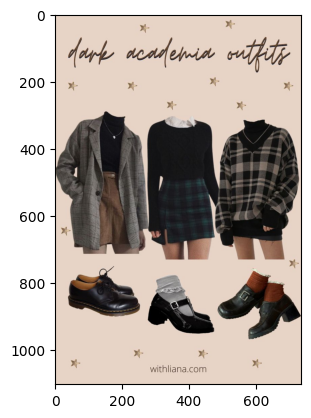

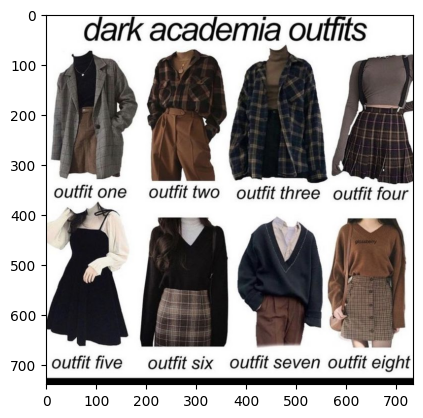

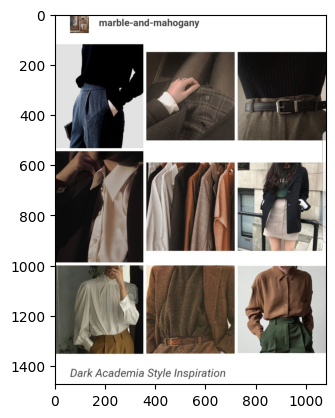

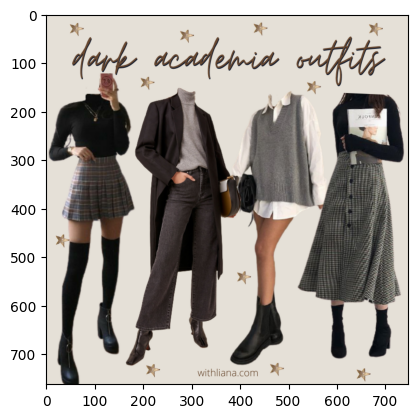

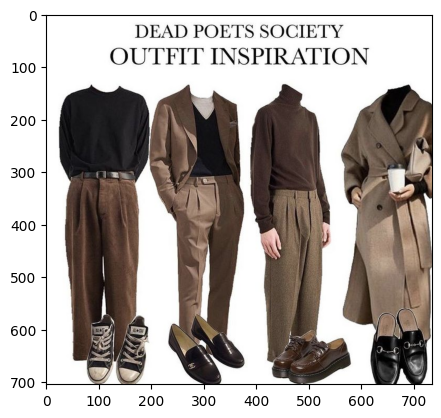

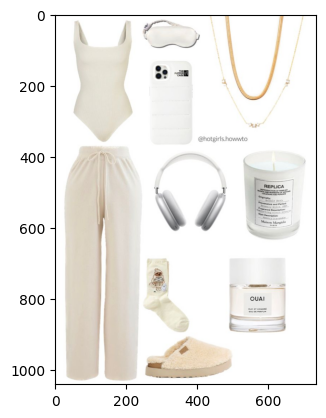

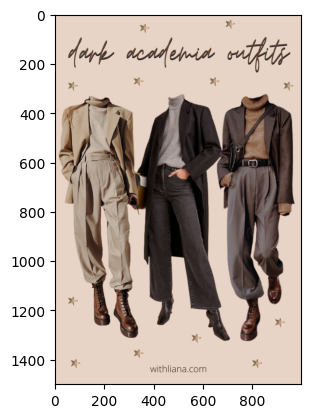

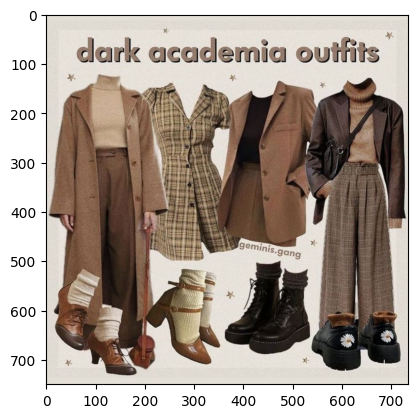


assistant: Here are some images of dark academia fashion style with formal outfits:

1. ![Dark Academia Outfit](https://i.pinimg.com/736x/73/a8/ed/73a8ede5ce2423edccb303b01b7946f0.jpg)
2. ![Dark Academia Look](https://i.pinimg.com/736x/0f/13/65/0f1365f6f58a23ce3df2a634f3f58c36.jpg)
3. ![Formal Dark Academia Attire](https://i.pinimg.com/originals/67/62/ca/6762cadffbcd7a97fa99ca2b2217b7b5.jpg)
4. ![Sophisticated Dark Academia Ensemble](https://i.pinimg.com/originals/2d/86/30/2d8630c5f279a5faff40a80575267c5c.png)
5. ![Elegant Dark Academia Fashion](https://i.pinimg.com/736x/0f/0e/5d/0f0e5d5dc118a5fcd3d964df04afef6d.jpg)
6. ![Dark Academia Clothing Style](https://i.pinimg.com/736x/d2/c5/0f/d2c50f9bb3509a7304b2bb15012b9701.jpg)
7. ![Vintage-inspired Dark Academia Outfit](https://i.pinimg.com/originals/81/54/6a/81546a171d300b795a6f27221ea30ab7.png)
8. ![Chic Dark Academia Apparel](https://i.pinimg.com/736x/c9/bf/45/c9bf45f531bd402dd84f6fe562555158.jpg)

These images feature the dark color p

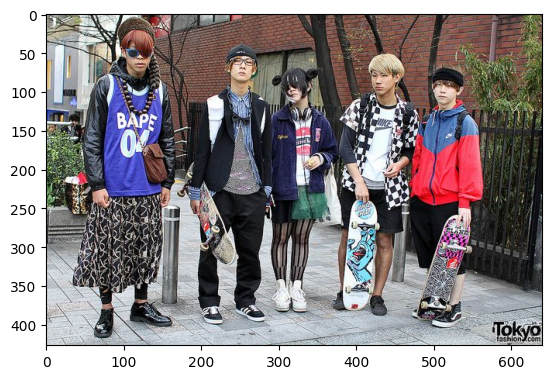

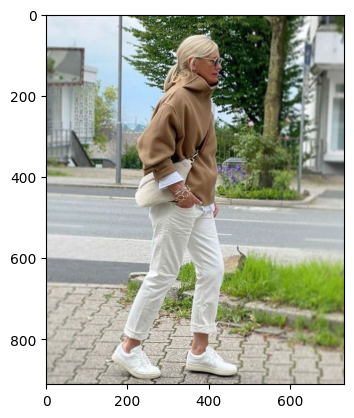

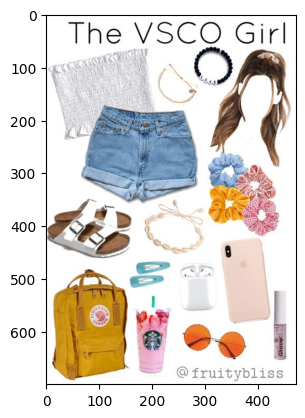

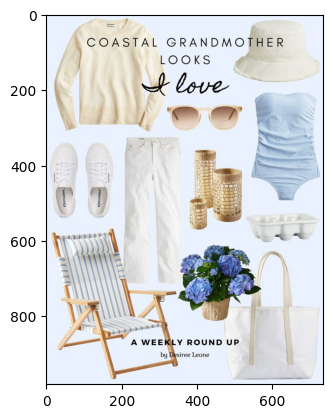

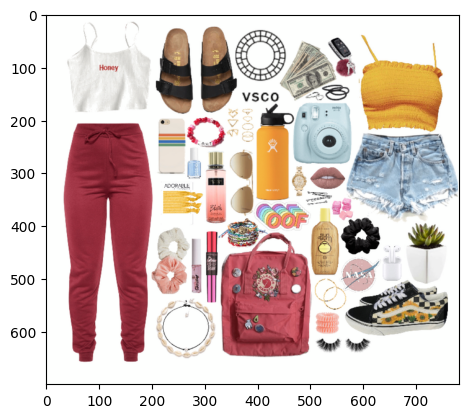

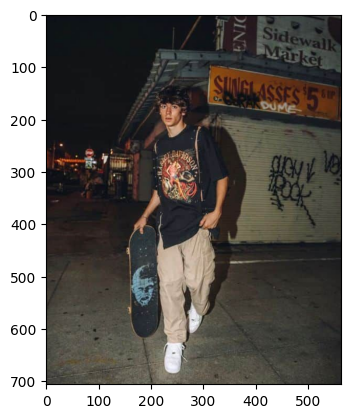

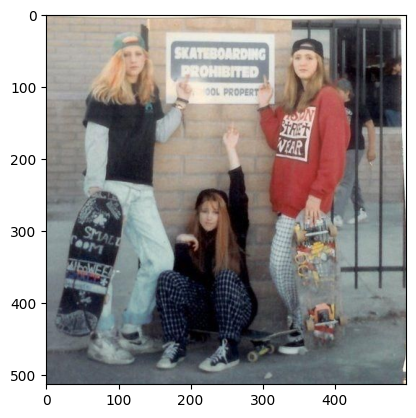

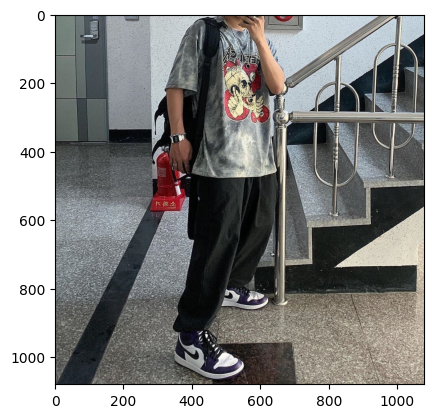

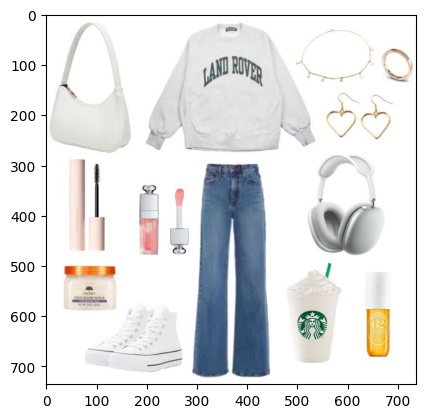


assistant: Here are some images of urban, casual, and athletic style outfits:

1. ![Casual Athletic Urban Outfit](https://i.pinimg.com/736x/2d/60/34/2d6034161748a56eb02d4c9f62dfc775.jpg)
2. ![Urban Style with Hoodie and Sneakers](https://i.pinimg.com/736x/ed/69/6a/ed696a9deff062c604fd1d48ffedb666.jpg)
3. ![Athletic Casual Urban Look](https://i.pinimg.com/474x/c6/d0/b0/c6d0b074ec366ba8c9db3823b2ede86a.jpg)
4. ![Sporty Urban Outfit](https://i.pinimg.com/736x/db/89/90/db8990f28f4702ab34841eec9cad1d6f.jpg)
5. ![Streetwear with Athletic Vibe](https://i.pinimg.com/originals/12/5b/5b/125b5badfb05903812492ed37243a447.png)
6. ![Urban Fashion with Sneakers](https://i.pinimg.com/564x/96/12/91/961291233daa54ded37ab34160a2b0e6.jpg)
7. ![Relaxed Athletic Ensemble](https://i.pinimg.com/564x/45/a1/29/45a12986ff8dfe38f8a2907df41f5843.jpg)
8. ![Urban Athleisure Wear](https://i.pinimg.com/originals/c6/ff/2f/c6ff2ff5b51e5fa2b622640d4164eaf2.jpg)
9. ![Casual Urban Athletic Attire](https://i.pinimg.com/736

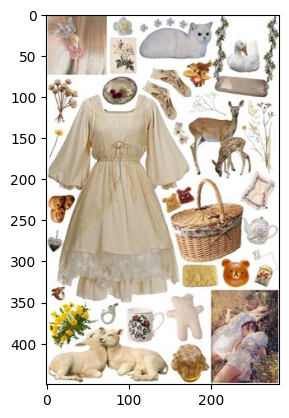

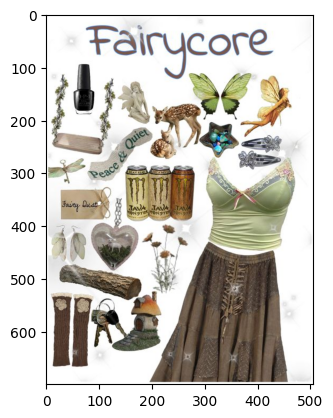

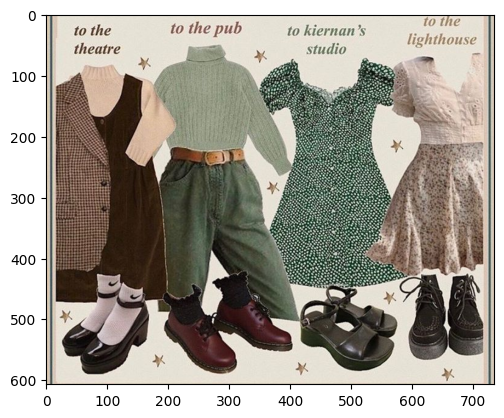

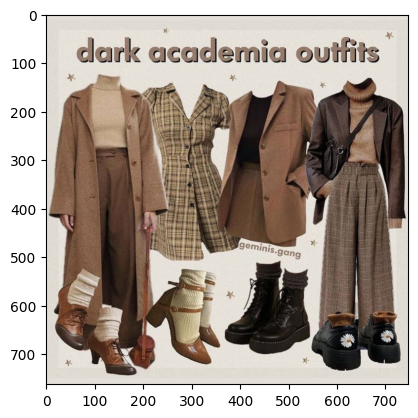

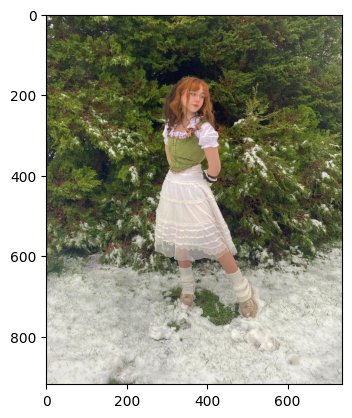

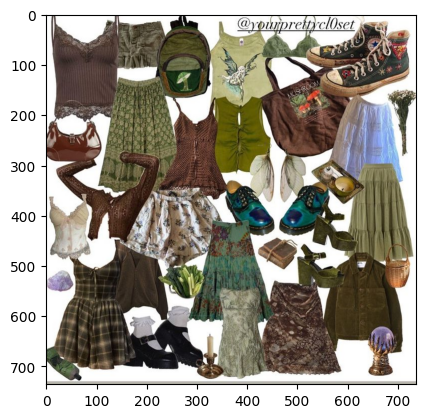

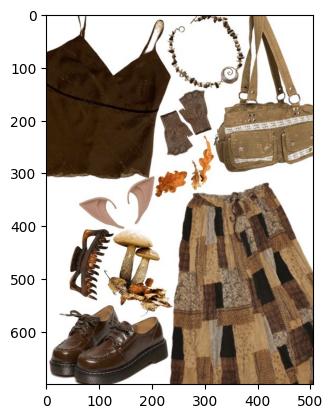

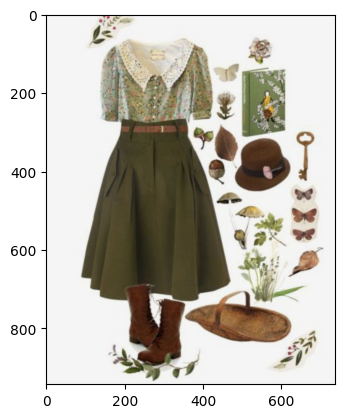


assistant: Here are some images of nature-inspired outfits:

1. ![Nature-inspired Outfit with Earth Tones](https://i.pinimg.com/474x/14/93/6a/14936a5ec2015a22eb70a236c5334918.jpg)
2. ![Floral Dress Nature Inspired](https://i.pinimg.com/564x/57/f6/82/57f6820ecc0a40bb13ebe0a7fd3a911f.jpg)
3. ![Natural Textures and Earthy Tones](https://i.pinimg.com/736x/e2/f4/da/e2f4da77d5eb28dc0aa05738a4495301.jpg)
4. ![Botanical Print Outfit](https://i.pinimg.com/originals/c9/bf/45/c9bf45f531bd402dd84f6fe562555158.png)
5. ![Casual Nature-inspired Ensemble](https://i.pinimg.com/736x/11/04/ce/1104ce11f25927eba273a502eaf1475b.jpg)
6. ![Outdoor Connection Outfit](https://i.pinimg.com/736x/d5/86/f9/d586f990960f2b74009454d0406fcea0.jpg)
7. ![Earthy Nature-inspired Look](https://i.pinimg.com/564x/e5/f9/13/e5f9132aafc22d84e55c75676435884b.jpg)
8. ![Green and Brown Nature Palette](https://i.pinimg.com/736x/64/79/ed/6479ed7e424e8eb6beb5a43c61f0987b.jpg)

These outfits incorporate earth tones like green, brown, 

In [ ]:
messages = []
messages.append({"role": "system", "content": "For style_search function calls, include a description of the visuals associated with the style (colors, textures, etc.). DO NOT simply state the name of the style. If unfamiliar with the style, search the web for a description, then use style_search."})
while(True):
    pretty_convo([messages[-1]])
    user_input = input("User: ")
    if user_input == "exit":
        break
    messages.append({"role": "user", "content": user_input})
    pretty_convo([messages[-1]])
    chat_response = chat_completion_request(
        messages, functions=functions
    )
    assistant_message = chat_response.json()["choices"][0]["message"]
    messages.append(assistant_message)
    if assistant_message.get("function_call"):
        pretty_convo([messages[-1]])
        results = execute_function_call(assistant_message)
        messages.append({"role": "function", "name": assistant_message["function_call"]["name"], "content": results})
        chat_response = chat_completion_request(
            messages, functions=functions
        )
        assistant_message = chat_response.json()["choices"][0]["message"]
        messages.append(assistant_message)
    print()